# Regression sur l'influence des meta-données des données de DGML sur la performance des algorithmes entraînés

Dans ce notebook,nous essayons de déterminer les meta-données des jeux de données présents sur DGML influeçant le plus la performance des algorithmes entraînés et testés par AutoML à l'aide d'une regression.

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [1]:
#pour créer le csv des expe de DGML:
#main_csv = pd.read_csv('open_data_ml_datasets_all_targets.csv')
#open_ml_datasets = pd.read_csv('best_datasets_ml_for_csvconf_eval.csv') 
#dgml_exp = pd.merge(main_csv,open_ml_datasets,how='inner',on=['title'])
#dgml_exp.to_csv('dgml_datasets.csv',index=None)

Lecture du JDD des données de DGML (uniquement classification):

In [4]:
dgml_classif = pd.read_csv('dgml_classif.csv')

On dispose de :

In [5]:
len(dgml_classif)

272

jeux de données avec les meta-données suivantes:

In [5]:
dgml_classif.columns

Index(['title', 'dgf_dataset_url', 'dgf_dataset_id', 'dgf_resource_url',
       'nb_lines', 'nb_features', 'profile_url', 'automl_url',
       'target_variable', 'task', 'dgf_resource_id', 'best_model',
       'metric_type', 'metric_value', 'score', 'missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance'],
      dtype='object')

On s'intéresse uniquement à `['title','dgf_dataset_id','nb_lines', 'nb_features','target_variable', 'task','best_model',
       'metric_type', 'metric_value','missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance']`

In [6]:
dgml_classif = dgml_classif[['title','dgf_dataset_id','nb_lines', 'nb_features','target_variable', 'task','best_model',
       'metric_type', 'metric_value','missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance']]

A ces 269 jeux de données on rajoute les JDD curated:

In [7]:
len(dgml_classif)

272

On dispose d'assez de données pour étudier l'influence des meta-données sur la performance des algoithmes.

## 1. Tout algorithme confondu

In [8]:
features = ['nb_lines', 'nb_features','missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance']

In [7]:
dgml_classif.head()

,title,dgf_dataset_id,nb_lines,nb_features,target_variable,task,best_model,metric_type,metric_value,missing_cells_pct,nb_numerical,nb_categorical,nb_classes_target,imbalance
0,Budget Primitif - 2017 - Angers Loire M�tropole,5e3221e106e3e70513320bab,1936,13,Mode de gestion,binary_classification,4_Default_Xgboost,logloss,0.197438,0.5,4,9,2,0.190962
1,Horaires des �coles �l�mentaires et primaires ...,5e32233c06e3e708b6320bb5,2834,35,CODE_NATURE,binary_classification,Ensemble,logloss,0.680797,9.7,3,30,2,0.000200
2,Horaires des �coles �l�mentaires et primaires ...,5e32233c06e3e708b6320bb5,2834,35,MULTI_RYTHME,binary_classification,Ensemble,logloss,0.152802,9.7,3,30,2,0.426888
3,Horaires des �coles �l�mentaires et primaires ...,5e32233c06e3e708b6320bb5,2834,35,LUNDI_MATIN_DEBUT,multiclass_classification,4_Default_Xgboost,logloss,0.004056,9.7,3,30,12,0.196180
4,Horaires des �coles �l�mentaires et primaires ...,5e32233c06e3e708b6320bb5,2834,35,LUNDI_MATIN_FIN,multiclass_classification,4_Default_Xgboost,logloss,0.004025,9.7,3,30,12,0.315952


Je transforme le pourcentage des valeurs manquantes en un entier compris entre 0 et 1:

In [8]:
dgml_classif['missing_cells_pct']=dgml_classif['missing_cells_pct'].apply(lambda x: x/100)

Certains algorithmes (tels que SVM) sont très sensibles à la standardisation des données: nous allons faire un test sans et avec standardisation:

In [29]:
dgml_classif.columns

Index(['title', 'dgf_dataset_id', 'nb_lines', 'nb_features', 'target_variable',
       'task', 'best_model', 'metric_type', 'metric_value',
       'missing_cells_pct', 'nb_numerical', 'nb_categorical',
       'nb_classes_target', 'imbalance'],
      dtype='object')

In [8]:
features

['nb_lines',
 'nb_features',
 'missing_cells_pct',
 'nb_numerical',
 'nb_categorical',
 'nb_classes_target',
 'imbalance']

In [9]:
X = dgml_classif[features]
y = dgml_classif['metric_value']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

### Sans standardisation

#### 1. Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
lr = LinearRegression()

In [12]:
lr.fit(X_train,y_train)

LinearRegression()

In [13]:
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Test set score: 0.15


#### 2. SVR

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

In [36]:
svr = SVR() 

In [16]:
pipe = make_pipeline(svr)

In [17]:
import numpy as np

In [64]:
param_grid_svr = {'svr__kernel':['linear', 'poly', 'rbf'],
             "svr__C": [0.1,1.0],
              "svr__gamma": ['scale','auto'],
              "svr__epsilon":[0.1,0.01]}

In [38]:
from sklearn.model_selection import GridSearchCV

In [20]:
grid = GridSearchCV(pipe, param_grid=param_grid_svr,cv=5)

In [ ]:
grid.fit(X_train,y_train)

In [151]:
grid.best_params_

{'svr__C': 1.0,
 'svr__epsilon': 0.1,
 'svr__gamma': 'auto',
 'svr__kernel': 'rbf'}

In [152]:
grid.score(X_test,y_test)

0.28758654849431275

#### 3. Decision Tree

In [39]:
from sklearn.tree import DecisionTreeRegressor

In [29]:
import numpy as np

In [40]:
param_grid_decisiontree = {"decisiontreeregressor__criterion": ["mse", "friedman_mse"],
"decisiontreeregressor__max_depth": np.arange(2, 30, 1),
}

In [41]:
decisiontree = DecisionTreeRegressor()

In [31]:
pipe = make_pipeline(decisiontree)
grid = GridSearchCV(pipe, param_grid=param_grid_decisiontree, cv=5)

NameError: name 'GridSearchCV' is not defined

In [102]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__criterion': ['mse',
                                                              'friedman_mse'],
                         'decisiontreeregressor__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [103]:
grid.best_params_

{'decisiontreeregressor__criterion': 'friedman_mse',
 'decisiontreeregressor__max_depth': 3}

In [105]:
grid.score(X_test,y_test)

0.19134798202603365

#### 4. RandomForestRegressor

In [42]:
from sklearn.ensemble import RandomForestRegressor

In [43]:
param_grid_rf = {'randomforestregressor__n_estimators': [10,100, 200, 400],
            'randomforestregressor__max_depth': [4, 6, 8, 10, 12, 15],
       'randomforestregressor__max_features': ["auto"],
          'randomforestregressor__min_samples_split': [2,10, 20, 30],
             }

In [44]:
rf =  RandomForestRegressor()

In [220]:
pipe = make_pipeline(rf)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [221]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [4, 6, 8, 10, 12,
                                                              15],
                         'randomforestregressor__max_features': ['auto'],
                         'randomforestregressor__min_samples_split': [2, 10, 20,
                                                                      30],
                         'randomforestregressor__n_estimators': [10, 100, 200,
                                                                 400]})

In [222]:
grid.score(X_test,y_test)

0.4156882312953687

#### 5. GradientBoostRegressor

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

In [46]:
gbr = GradientBoostingRegressor()

In [47]:
param_grid_gbr = {'gradientboostingregressor__n_estimators': [10,100, 200, 400],
             'gradientboostingregressor__max_depth': [3,4, 6, 8, 10, 12, 15],
             'gradientboostingregressor__max_features': [None],
             'gradientboostingregressor__min_samples_split': [2,10, 20, 30]}

In [231]:
pipe = make_pipeline(gbr)
grid = GridSearchCV(pipe, param_grid=param_grid_gbr, cv=5)

In [232]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             param_grid={'gradientboostingregressor__max_depth': [3, 4, 6, 8,
                                                                  10, 12, 15],
                         'gradientboostingregressor__max_features': [None],
                         'gradientboostingregressor__min_samples_split': [2, 10,
                                                                          20,
                                                                          30],
                         'gradientboostingregressor__n_estimators': [10, 100,
                                                                     200,
                                                                     400]})

In [233]:
grid.score(X_test,y_test)

0.36986070173987895

#### 6. MLP

In [48]:
from sklearn.neural_network import MLPRegressor

In [49]:
mlp = MLPRegressor()

In [242]:
mlp.fit(X_train,y_train)

/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/giulia/anaconda3/lib/python3.8/sit

GridSearchCV(cv=5, estimator=Pipeline(steps=[('mlpregressor', MLPRegressor())]),
             param_grid={'mlpregressor__activation': ['tanh', 'relu'],
                         'mlpregressor__alpha': [0.0001, 0.05],
                         'mlpregressor__hidden_layer_sizes': [(50, 50, 50),
                                                              (50, 100, 50),
                                                              (100,)],
                         'mlpregressor__learning_rate': ['constant',
                                                         'adaptive'],
                         'mlpregressor__solver': ['sgd', 'adam']})

In [243]:
mlp.score(X_test,y_test)

0.31429114754829623

#### 7. XGBoost Regressor

In [50]:
from xgboost import XGBRegressor

In [51]:
xgboost = XGBRegressor()

In [52]:
param_grid_xgboost = {
    "xgbregressor__objective": ["reg:squarederror"],
    "xgbregressor__eval_metric": ["rmse"],
    "xgbregressor__eta": [0.05, 0.075, 0.1, 0.15],
    "xgbregressor__max_depth": [1, 2, 3, 4],
    "xgbregressor__min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "xgbregressor__subsample": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "xgbregressor__colsample_bytree": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

In [252]:
pipe = make_pipeline(xgboost)
grid = GridSearchCV(pipe, param_grid=param_grid_xgboost, cv=5)

In [253]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     min_child_weight=None,
                             

In [254]:
grid.score(X_test,y_test)

0.4866701139730315

### Avec StandardScaler

#### 1. Linear Regression

In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
stscaler = StandardScaler()

In [55]:
lr = LinearRegression()

In [260]:
pipe = make_pipeline(stscaler,lr)

In [261]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [262]:
pipe.score(X_test,y_test)

0.15095501640607922

#### 2. SVR

In [264]:
pipe = make_pipeline(stscaler,svr)

In [270]:
grid = GridSearchCV(pipe, param_grid=param_grid_svr,cv=5)

In [271]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [0.1, 1.0], 'svr__epsilon': [0.1, 0.01],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['linear', 'poly', 'rbf']})

In [272]:
grid.score(X_test,y_test)

0.28845203797388586

### 3. DecisionTreeRegressor

In [192]:
pipe = make_pipeline(stscaler,decisiontree)

In [193]:
grid = GridSearchCV(pipe, param_grid=param_grid_decisiontree,cv=5)

In [194]:
grid.fit(X_train,y_train)

/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = trans

/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = trans

/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = trans

/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 355, in __call__
    return self.func(*args, **kwargs)
  File "/home/giulia/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = trans

ValueError: could not convert string to float: 'binary_classification'

In [195]:
grid.score(X_test,y_test)

AttributeError: 'GridSearchCV' object has no attribute 'scorer_'

### 4.RandomForestRegressor

In [277]:
pipe = make_pipeline(stscaler,rf)

In [278]:
grid = GridSearchCV(pipe, param_grid=param_grid_rf,cv=5)

In [279]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [4, 6, 8, 10, 12,
                                                              15],
                         'randomforestregressor__max_features': ['auto'],
                         'randomforestregressor__min_samples_split': [2, 10, 20,
                                                                      30],
                         'randomforestregressor__n_estimators': [10, 100, 200,
                                                                 400]})

In [280]:
grid.score(X_test,y_test)

0.44555456281044026

#### 5.GradientBoostingRegressor

In [281]:
pipe = make_pipeline(stscaler,gbr)

In [282]:
grid = GridSearchCV(pipe, param_grid=param_grid_gbr,cv=5)

In [283]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             param_grid={'gradientboostingregressor__max_depth': [3, 4, 6, 8,
                                                                  10, 12, 15],
                         'gradientboostingregressor__max_features': [None],
                         'gradientboostingregressor__min_samples_split': [2, 10,
                                                                          20,
                                                                          30],
                         'gradientboostingregressor__n_estimators': [10, 100,
                                                                     200,
                                                                     400]})

In [284]:
grid.score(X_test,y_test)

0.4156105970263638

#### 6. MLPRegressor

In [285]:
pipe = make_pipeline(stscaler,mlp)

In [286]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor', MLPRegressor())])

In [287]:
pipe.score(X_test,y_test)

0.15609362637438706

#### 7. XGBoostRegressor

In [288]:
pipe = make_pipeline(stscaler,xgboost)

In [289]:
grid = GridSearchCV(pipe,param_grid=param_grid_xgboost,cv=5)

In [290]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                            

In [291]:
grid.score(X_test,y_test)

0.516712834207059

### Avec MinMaxScaler

In [81]:
from sklearn.preprocessing import MinMaxScaler

In [82]:
mmscaler = MinMaxScaler()

#### 1. Linear Regression

In [294]:
pipe = make_pipeline(mmscaler,lr)

In [295]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [296]:
pipe.score(X_test,y_test)

0.15095501640607933

#### 2.SVR

In [297]:
pipe = make_pipeline(mmscaler,svr)

In [298]:
grid = GridSearchCV(pipe, param_grid=param_grid_svr,cv=5)

In [299]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [0.1, 1.0], 'svr__epsilon': [0.1, 0.01],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['linear', 'poly', 'rbf']})

In [300]:
grid.score(X_test,y_test)

0.26758422558812944

#### 3. DecisionTree

In [301]:
pipe = make_pipeline(mmscaler,decisiontree)

In [302]:
grid = GridSearchCV(pipe, param_grid=param_grid_decisiontree,cv=5)

In [303]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__criterion': ['mse',
                                                              'friedman_mse'],
                         'decisiontreeregressor__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [304]:
grid.score(X_test,y_test)

0.0942885994213819

#### 4. RandomForestRegressor

In [305]:
pipe = make_pipeline(mmscaler,rf)

In [306]:
grid = GridSearchCV(pipe, param_grid=param_grid_rf,cv=5)

In [307]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [4, 6, 8, 10, 12,
                                                              15],
                         'randomforestregressor__max_features': ['auto'],
                         'randomforestregressor__min_samples_split': [2, 10, 20,
                                                                      30],
                         'randomforestregressor__n_estimators': [10, 100, 200,
                                                                 400]})

In [308]:
grid.score(X_test,y_test)

0.4012698829936837

#### 5. GradientBoostingRegressor

In [309]:
pipe = make_pipeline(mmscaler,gbr)

In [310]:
grid = GridSearchCV(pipe, param_grid=param_grid_gbr,cv=5)

In [311]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             param_grid={'gradientboostingregressor__max_depth': [3, 4, 6, 8,
                                                                  10, 12, 15],
                         'gradientboostingregressor__max_features': [None],
                         'gradientboostingregressor__min_samples_split': [2, 10,
                                                                          20,
                                                                          30],
                         'gradientboostingregressor__n_estimators': [10, 100,
                                                                     200,
                                                                     400]})

In [312]:
grid.score(X_test,y_test)

0.43763870659635207

#### 6. MLPRegressor

In [313]:
pipe = make_pipeline(mmscaler,mlp)

In [316]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('mlpregressor', MLPRegressor())])

In [318]:
pipe.score(X_test,y_test)

0.16948233594844953

#### 7. XGBoostRegressor

In [319]:
pipe = make_pipeline(mmscaler,xgboost)

In [320]:
grid = GridSearchCV(pipe, param_grid=param_grid_xgboost,cv=5)

In [321]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                

In [322]:
grid.score(X_test,y_test)

0.4639779626688225

## Premiers résultats

In [1]:
algos = ['Linear Regression', 'SVR','DecisionTree','RandomForestRegressor','GradientBoostingRegressor','MLPRegressor','XGBoostRegressor','Linear Regression', 'SVR','DecisionTree','RandomForestRegressor','GradientBoostingRegressor','MLPRegressor','XGBoostRegressor','Linear Regression', 'SVR','DecisionTree','RandomForestRegressor','GradientBoostingRegressor','MLPRegressor','XGBoostRegressor']

In [2]:
data_standardisation = [None,None,None,None,None,None,None,'StandardScaler','StandardScaler','StandardScaler','StandardScaler','StandardScaler','StandardScaler','StandardScaler','MinMaxScaler','MinMaxScaler','MinMaxScaler','MinMaxScaler','MinMaxScaler','MinMaxScaler','MinMaxScaler']

In [9]:
r2 = [0.15,0.28,0.19,0.41,0.37,0.31,0.48,0.15,0.28,0.19,0.44,0.41,0.15,0.51,0.15,0.26,0.09,0.4,0.43,0.16,0.46]

In [10]:
df = pd.DataFrame(list(zip(algos, data_standardisation,r2)),
               columns =['Algorithm', 'Data_Standardization','R2'])

In [11]:
df

,Algorithm,Data_Standardization,R2
0,Linear Regression,None,0.15
1,SVR,None,0.28
2,DecisionTree,None,0.19
3,RandomForestRegressor,None,0.41
4,GradientBoostingRegressor,None,0.37
5,MLPRegressor,None,0.31
6,XGBoostRegressor,None,0.48
7,Linear Regression,StandardScaler,0.15
8,SVR,StandardScaler,0.28
9,DecisionTree,StandardScaler,0.19


Le meilleur résultat obtenu, un R² de 0.51 avec XGBoostRegressor n'est pas satisfaisant.

On ajoute de nouvelles features pour essayer d'améliorer notre algorithme.

## 2. Ajout de features

On considère deux features catégorielles supplémentaires dans notre analyse:
1. `task`: variable catégorielle binaire (binary_classification ou multiclass_classification) <br>
2. `best_model`: variable catégorielle du nom du meilleur algorithme pour ce jeu de données

Encoding de ces deux variables:

In [120]:
dgml_classif = pd.read_csv('dgml_classif.csv')
features = ['nb_lines', 'nb_features','missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance','task','best_model','score']

In [121]:
dgml_classif['missing_cells_pct']=dgml_classif['missing_cells_pct'].apply(lambda x: x/100)

In [122]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [123]:
one_hot_enc = OneHotEncoder(handle_unknown = 'ignore')

In [124]:
X = dgml_classif[features]
y = dgml_classif['metric_value']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [125]:
num_cols = ['nb_lines', 'nb_features','missing_cells_pct',
       'nb_numerical', 'nb_categorical', 'nb_classes_target', 'imbalance','score']
cat_cols = ['task','best_model']

In [161]:
columns_trans =  make_column_transformer((stscaler,num_cols),(one_hot_enc,cat_cols))

### 1. Linear Regression

In [162]:
pipe = make_pipeline(columns_trans,lr)

In [163]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['nb_lines', 'nb_features',
                                                   'missing_cells_pct',
                                                   'nb_numerical',
                                                   'nb_categorical',
                                                   'nb_classes_target',
                                                   'imbalance', 'score']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['task', 'best_model'])])),
                ('linearregression', LinearRegression())])

In [164]:
pipe.score(X_test,y_test)

0.6010996874241652

### 2. SVR

In [165]:
pipe = make_pipeline(columns_trans,svr)

In [166]:
grid = GridSearchCV(pipe, param_grid=param_grid_svr,cv=5)

In [167]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance',
                                                                          'score']),
                   

In [168]:
grid.score(X_test,y_test)

0.799224012117489

### 3. DecisionTreeRegressor

In [301]:
columns_trans =  make_column_transformer((one_hot_enc,cat_cols),remainder="passthrough")

In [302]:
pipe = make_pipeline(columns_trans,decisiontree)

In [303]:
grid = GridSearchCV(pipe, param_grid=param_grid_decisiontree,cv=5)

In [304]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['task',
                                                                          'best_model'])])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__criterion': ['mse',
                                                              'friedman_mse'],
                         'decisiontreeregressor__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27,

In [305]:
grid.score(X_test,y_test)

0.8600745156803452

### 4. RandomForestRegressor

In [173]:
pipe = make_pipeline(columns_trans,rf)

In [174]:
grid = GridSearchCV(pipe, param_grid=param_grid_rf,cv=5)

In [175]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance',
                                                                          'score']),
                   

In [177]:
grid.score(X_test,y_test)

0.7775996969814308

### 5. GradientBoostingRegressor

In [139]:
columns_trans = make_column_transformer((mmscaler,num_cols),(one_hot_enc,cat_cols))

In [140]:
pipe = make_pipeline(columns_trans,gbr)

In [142]:
grid = GridSearchCV(pipe, param_grid=param_grid_gbr,cv=5)

In [143]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance',
                                                                          'score']),
                       

In [144]:
grid.score(X_test,y_test)

0.8306592875488416

### 6. MLPRegressor

In [179]:
columns_trans = make_column_transformer((stscaler,num_cols),(one_hot_enc,cat_cols))

In [180]:
pipe = make_pipeline(columns_trans,mlp)

In [183]:
param_grid_mlp = {"mlpregressor__hidden_layer_sizes" : [(50,50,50), (50,100,50),(100,)],
                       "mlpregressor__activation" : ["relu","tanh"], 
                       "mlpregressor__solver" : ["adam"], 
                       "mlpregressor__alpha" : [0.0001,0.001,0.00001], 
                       "mlpregressor__batch_size" : [100,200,300,"auto"],
                       "mlpregressor__learning_rate_init" : [0.0001,0.001,0.01], 
                       "mlpregressor__random_state" : [64]
                  }

In [184]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance',
                                                                          'score']),
                   

In [185]:
grid.score(X_test,y_test)

0.7834338032260096

### 7. XGBoostRegressor

In [130]:
columns_trans = make_column_transformer((stscaler,num_cols),(one_hot_enc,cat_cols))

In [131]:
pipe = make_pipeline(columns_trans,xgboost)

In [132]:
grid = GridSearchCV(pipe, param_grid=param_grid_xgboost,cv=5)

In [133]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['nb_lines',
                                                                          'nb_features',
                                                                          'missing_cells_pct',
                                                                          'nb_numerical',
                                                                          'nb_categorical',
                                                                          'nb_classes_target',
                                                                          'imbalance',
                                                                          'score']),
                   

In [134]:
grid.score(X_test,y_test)

0.7986027708336612

## Summary of results (with feature addition)

In [186]:
algos = ['Linear Regression', 'SVR','DecisionTree','RandomForestRegressor','GradientBoostingRegressor','MLPRegressor','XGBoostRegressor']

In [187]:
data_standardisation = ['StandardScaler','StandardScaler',None,'StandardScaler','MinMaxScaler',None,'StandardScaler']

In [306]:
r2 = [0.6,0.79,0.86,0.77,0.83,0.78,0.79]

In [307]:
df = pd.DataFrame(list(zip(algos, data_standardisation,r2)),
               columns =['Algorithm', 'Data_Standardization','R2'])

In [308]:
df

,Algorithm,Data_Standardization,R2
0,Linear Regression,StandardScaler,0.60
1,SVR,StandardScaler,0.79
2,DecisionTree,StandardScaler,0.86
3,RandomForestRegressor,StandardScaler,0.77
4,GradientBoostingRegressor,MinMaxScaler,0.83
5,MLPRegressor,None,0.78
6,XGBoostRegressor,StandardScaler,0.79


Nous choisissons d'analyser le DecisionTreeRegressor car cet algorithme donne les meilleurs résultats et ces résultats sont facilement explicables.

In [309]:
from sklearn import tree

In [310]:
model = grid.best_estimator_.named_steps['decisiontreeregressor']

In [311]:
model.

18

In [312]:
transformer= grid.best_estimator_.named_steps['columntransformer']

In [319]:
transformer.fit_transform(X_train)[0]

array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 3.41500000e+03, 5.00000000e+00,
       0.00000000e+00, 2.00000000e+00, 3.00000000e+00, 2.00000000e+00,
       2.27825000e-01, 5.70756843e+00])

In [323]:
one_hot = transformer.named_transformers_['onehotencoder']

In [324]:
one_hot.get_feature_names()

array(['x0_binary_classification', 'x0_multiclass_classification',
       'x1_2_DecisionTree', 'x1_3_Default_Xgboost',
       'x1_4_Default_NeuralNetwork', 'x1_4_Default_Xgboost',
       'x1_5_Default_NeuralNetwork', 'x1_5_Default_RandomForest',
       'x1_6_Default_RandomForest', 'x1_Ensemble'], dtype=object)

In [320]:
feature_names = np.array(['x0_binary_classification', 'x0_multiclass_classification',
       'x1_2_DecisionTree', 'x1_3_Default_Xgboost',
       'x1_4_Default_NeuralNetwork', 'x1_4_Default_Xgboost',
       'x1_5_Default_NeuralNetwork', 'x1_5_Default_RandomForest',
       'x1_6_Default_RandomForest', 'x1_Ensemble','nb_lines','nb_features', 'missing_cells_pct', 'nb_numerical',
       'nb_categorical', 'nb_classes_target', 'imbalance', 'score'])

In [321]:
import matplotlib.pyplot as plt

In [322]:
fig = plt.figure(figsize=(200,120))
tree.plot_tree(model,feature_names=feature_names,max_depth=4,filled=True,fontsize=80) 
fig.savefig('decision_tree.png')

In [326]:
import shap

In [327]:
explainer = shap.TreeExplainer(model)

In [328]:
shap_values = explainer.shap_values(transformer.fit_transform(X_train))

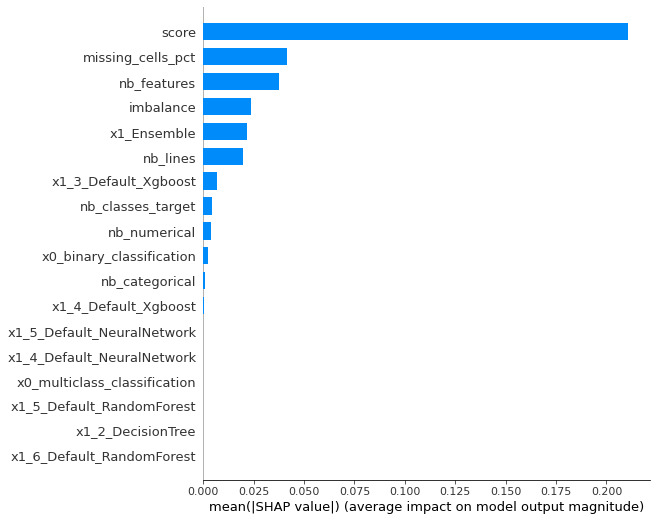

In [330]:
shap.summary_plot(shap_values, trasnf.fit_transform(X_train), plot_type="bar",feature_names=feature_names)

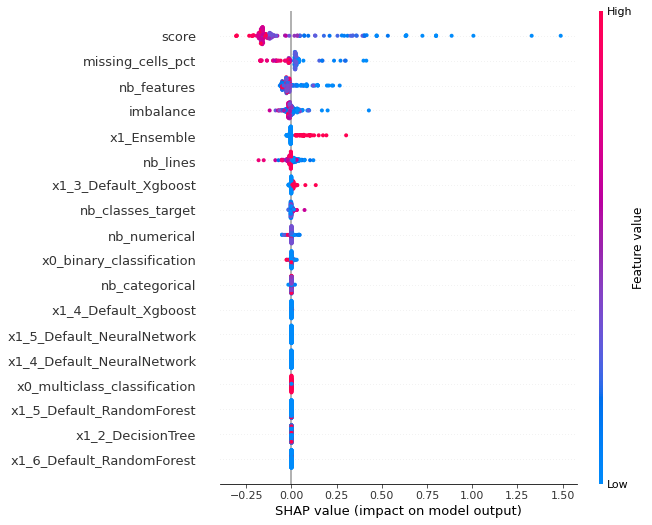

In [333]:
shap.summary_plot(shap_values, transformer.fit_transform(X_train),feature_names=feature_names)